In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os
import subprocess

#import seaborn as sns
import sys
import scipy
sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 

from sympy import *
import random
import math

import matplotlib as mpl
mpl.rcParams['figure.figsize']   = (18,10)
mpl.rcParams['font.size']        = 20 # standard er 45
mpl.rcParams['lines.color']      = 'r'
mpl.rcParams['lines.markersize'] = 20
plt.rcParams['figure.constrained_layout.use'] = True

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.546                      │        Ncalls = 80 (80 total)        │
│ EDM = 5.48e-07 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼──────

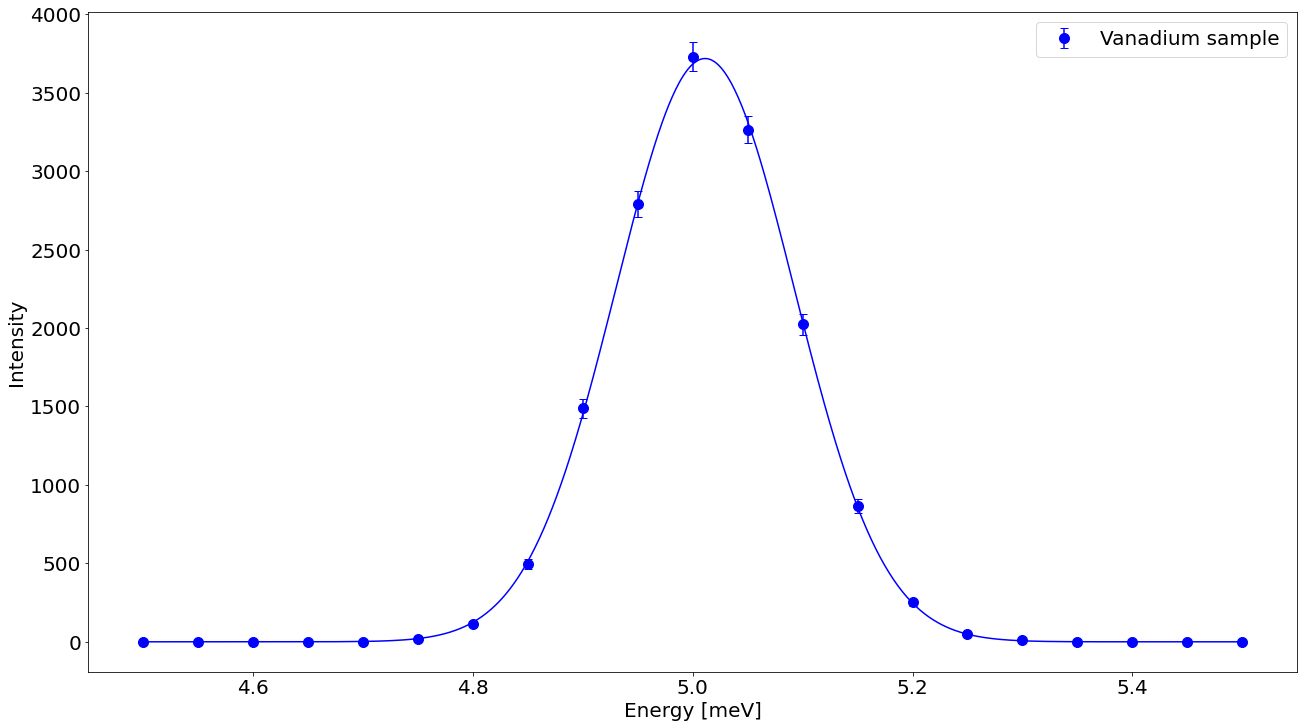

In [2]:
# Data treatment for perfoming a vanadium scan in McStas (SAMPLE = 1)

data_vana = np.loadtxt('/home/kristine/Documents/GitHub/ThALES_McStas/test_vana_1/mccode.dat') # Location of the vanadium scan

E = []

for i in range(len(data_vana)):
    E.append(data_vana[i][0])
    
intensity = []

for i in range(len(data_vana)):
    intensity.append(data_vana[i][9])
    
error = []

for i in range(len(data_vana)):
    error.append(data_vana[i][10])

def gauss(x,a,mu,sigma):
    return  a*np.exp(-(x-mu)** 2 / (2*sigma**2))

intensity= np.array(intensity)
E = np.array(E)
error = np.array(error)

chi2fitvana = Chi2Regression(gauss, E[intensity>1], intensity[intensity>1], error[intensity>1]) # Chi**2 fit 
minuitvana = Minuit(chi2fitvana, pedantic=False, a=4000, mu=5, sigma=0.1,print_level=1) # Guessing fitting parameters
minuitvana.migrad();
fit_parametersvana = minuitvana.args
fit_errorsvana = minuitvana.errors
Chi2_vana = minuitvana.fval

print(minuitvana.hesse())

print('FWHM=',2.35*fit_parametersvana[2])
    
x_range = np.linspace(np.min(E), np.max(E),1000)
    
plt.errorbar(E, intensity, error, fmt='b.', capsize=4, label='Vanadium sample')
plt.plot(x_range, gauss(x_range, *fit_parametersvana),'b')
plt.ylabel('Intensity')
plt.xlabel('Energy [meV]')
plt.legend()

In [4]:
# Python data treatment of the resolution component. 

### Should work with cov.py in the same file as script. If it does not work impliment 'np.savetxt('resplot_res_matrix.txt', Qres)' on line 207 
### and 'np.savetxt('resplot_cov_matrix.txt', Qcov)' on line 208 in cov.py inside the McStas packede installation. The script can be found under
### the mcresplot folder in McStas installation.

pathname_folder = '/home/kristine/Documents/GitHub/ThALES_McStas/ThALES_resolution_v2_20220107_151227' ## Pathname for the resolution scan folder where SAMPLE=0

def extract(pathname): # Functions extracts the energy FWHM og the resolution ellipsoide.

    path = str(pathname)
    to_folder_command = 'cd '+ path
    os.chdir(path)
    
    long_file = 'res_monitor_list.ki_x.ki_y.ki_z.kf_x.kf_y.kf_z.x.y.z.p_i.p_f'
    mc_ras_run = 'mcresplot '+long_file
    os.system(mc_ras_run)
    
    data = np.loadtxt('resplot_res_matrix.txt')
    
    cov_matrix = np.loadtxt('resplot_cov_matrix.txt')
    
    B = data[:3,:3]
    J = data[:-1,3]
    C = data[3,3]

    e = np.dot(J.T,np.dot(np.linalg.inv(B),J))

    FWHM = (2*np.sqrt(2*np.log(2)))*np.power(data[3,3]-e,-0.5)
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    

    fwhm_mueV = FWHM*1000
    
    return fwhm_mueV

print('FWHM_mueV=',extract(pathname_folder))



FWHM_mueV= 192.50997286446906
